In [4]:
import ffmpeg
import os

video_name = 'records_1'
with open(os.path.join(video_name, 'size.txt'), 'r') as fin:
    sizes = fin.read().split('x')
    width = int(sizes[0])
    height = int(sizes[1])

def config_stream(file, width=None, height=None, start=0, duration=None):
    if duration is None:
        s = ffmpeg.input(file, ss=start)
    else:
        s = ffmpeg.input(file, ss=start, t=duration)
    
    if width is None or int(width) < 0:
        width = -1
    if height is None or int(height) < 0:
        height = -1
    
    if not (width == -1 and height == -1):
        s.filter('scale', width, height)
    
    return s

def read_images(filepath, width=None, height=None):
    img_list = []
    with open(filepath, 'r') as fin:
        lines = fin.readlines()
        state = 'start'
        file = ''
        total_time = 0
        for line in lines:
            if line.startswith("file '"):
                file = line[6:-2]
                if not os.path.isabs(file):
                    file = os.path.join(os.path.dirname(filepath), file)
                if state == 'has_file':
                    img_list.append(config_stream(file, width, height, total_time))
                    state = 'start'
                elif state == 'start':
                    state = 'has_file'
            elif line.startswith("duration "):
                duration = float(line[9:])
                if state == 'has_file':
                    img_list.append(config_stream(file, width, height, total_time, duration))
                    total_time += duration
                    state = 'start'
        if state == 'has_file':
            img_list.append(config_stream(file, width, height, total_time))
        return ffmpeg.concat(*img_list)


imgs = read_images(video_name + '/img.txt')

audio = (
    ffmpeg
    .input(video_name + '/audio.wav')
)
(
    ffmpeg
    .output(imgs, audio, video_name + '.mp4', pix_fmt='yuv420p')
    .run(overwrite_output=True)
)

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100

(None, None)

In [8]:
import glob
import os
import subprocess

import ffmpeg

def insert_player_id(id: str, input_path, output_path):
    (
        ffmpeg
        .input(input_path)
        .drawtext(
            text='Player',
            fontsize='round(sqrt(w*h/50))',
            x='(w-tw)/2',
            y='((h-text_h)/2)-(text_h-(th/4))',
            fontfile='assets/fonts/NotoSansTC-Bold.otf',
            fontcolor='white',
            borderw=4,
            enable='between(t,0,3)'
        )
        .drawtext(
            text=id,
            fontsize='round(sqrt(w*h/50))',
            x='(w-tw)/2',
            y='((h-text_h)/2)+(text_h-(th/4))',
            fontfile='assets/fonts/NotoSansTC-Bold.otf',
            fontcolor='white',
            borderw=4,
            enable='between(t,0,3)'
        )
        .output(output_path)
        .run(overwrite_output=True)
    )

def generate_video(video_path, output_path, id: str, width=None, height=None, remove_original=False):
    try:
        with open(os.path.join(video_path, 'size.txt'), 'r') as fin:
            sizes = fin.read().split('x')
            width = width or int(sizes[0])
            height = height or int(sizes[1])
    except:
        width = width or -1
        height = height or -1

    cwd = os.getcwd()
    os.chdir(video_path)
    try:
        result = subprocess.run([
            'ffmpeg',
            '-y',
            '-f', 'concat',
            '-i', 'img.txt',
            '-i', 'audio.wav',
            '-pix_fmt', 'yuv420p',
            '-vf', f'scale={width}:{height},setsar=1:1',
            'tmp.mp4'
        ], check=True)
    except:
        result = -1
    
    os.chdir(cwd)
    
    insert_player_id(id, os.path.join(video_path, 'tmp.mp4'), output_path)
    os.remove(os.path.join(video_path, 'tmp.mp4'))

    if remove_original:
        if os.path.abspath(os.path.dirname(output_path)) == os.path.abspath(video_path):
            path_all = glob.glob(os.path.abspath(video_path) + '/**/*', recursive=True)
            path_remove=[filename for filename in path_all if not filename == output_path]
            [os.remove(filePath) for filePath in path_remove]
        else:
            for root, dirs, files in os.walk(os.path.abspath(video_path), topdown=False):
                for name in files:
                    os.remove(os.path.join(root, name))
                for name in dirs:
                    os.rmdir(os.path.join(root, name))
            os.rmdir(os.path.abspath(video_path))
    return result

video_name = 'records_1'
video_path = 'records_1'
output_path = os.path.join(os.getcwd(), video_name + '.mp4')
generate_video(video_path, output_path, 'timcsy', 960, 540, remove_original=False)

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100

CompletedProcess(args=['ffmpeg', '-y', '-f', 'concat', '-i', 'img.txt', '-i', 'audio.wav', '-pix_fmt', 'yuv420p', '-vf', 'scale=960:540,setsar=1:1', 'tmp.mp4'], returncode=0)

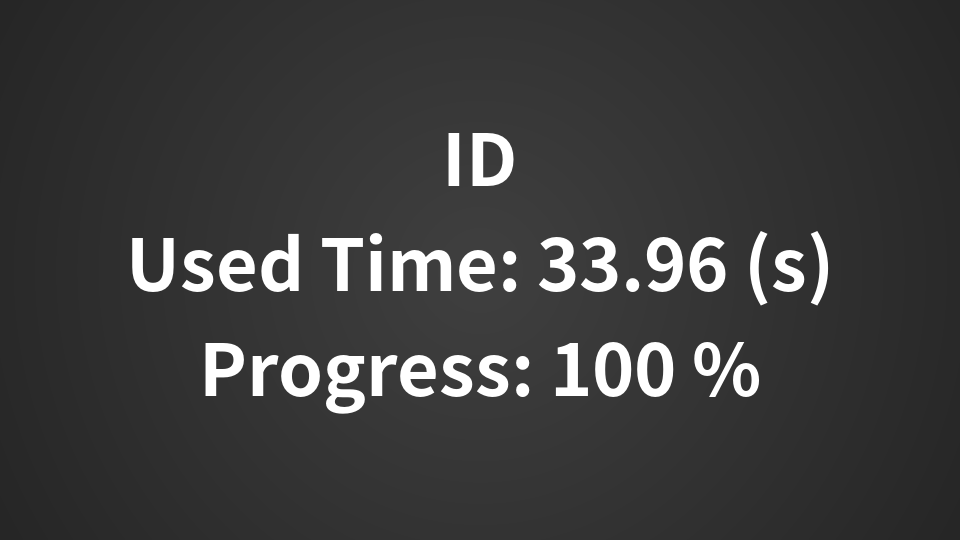

In [32]:
from PIL import Image, ImageDraw, ImageFont
import math
width = 960
height = 540
id = 'ID'
usedtime = 33.955545
progress = 0.999999

def result_image(width, height, id, usedtime, progress):
    image = Image.new('RGB', (width, height)) #Create the image

    innerColor = [64, 64, 64] # Color at the center
    outerColor = [32, 32, 32] # Color at the corners


    for y in range(height):
        for x in range(width):

            # Find the distance to the center
            distanceToCenter = math.sqrt((x - width / 2) ** 2 + (y - height / 2) ** 2)

            # Make it on a scale from 0 to 1
            distanceToCenter = float(distanceToCenter) / (math.sqrt(2) * width / 2)

            # Calculate r, g, and b values
            r = outerColor[0] * distanceToCenter + innerColor[0] * (1 - distanceToCenter)
            g = outerColor[1] * distanceToCenter + innerColor[1] * (1 - distanceToCenter)
            b = outerColor[2] * distanceToCenter + innerColor[2] * (1 - distanceToCenter)


            # Place the pixel        
            image.putpixel((x, y), (int(r), int(g), int(b)))


    font = ImageFont.truetype('assets/fonts/NotoSansTC-Bold.otf', 72)
    draw = ImageDraw.Draw(image)

    usedtime = round(usedtime, 2)
    progress = int(round(progress * 100, 0))

    id_w, th = draw.textsize(id, font)
    time_w, _ = draw.textsize(f'Used Time: {usedtime} (s)', font)
    pg_w, _ = draw.textsize(f'Progress: {progress} %', font)

    draw.text(((width - id_w) / 2, (height - 1.5 * th) / 2 - 1.5 * th + th / 4), id, '#FFFFFF', font)
    draw.text(((width - time_w) / 2, (height - 1.5 * th) / 2), f'Used Time: {usedtime} (s)', '#FFFFFF', font)
    draw.text(((width - pg_w) / 2, (height - 1.5 * th) / 2 + 1.5 * th - th / 4), f'Progress: {progress} %', '#FFFFFF', font)

    return image

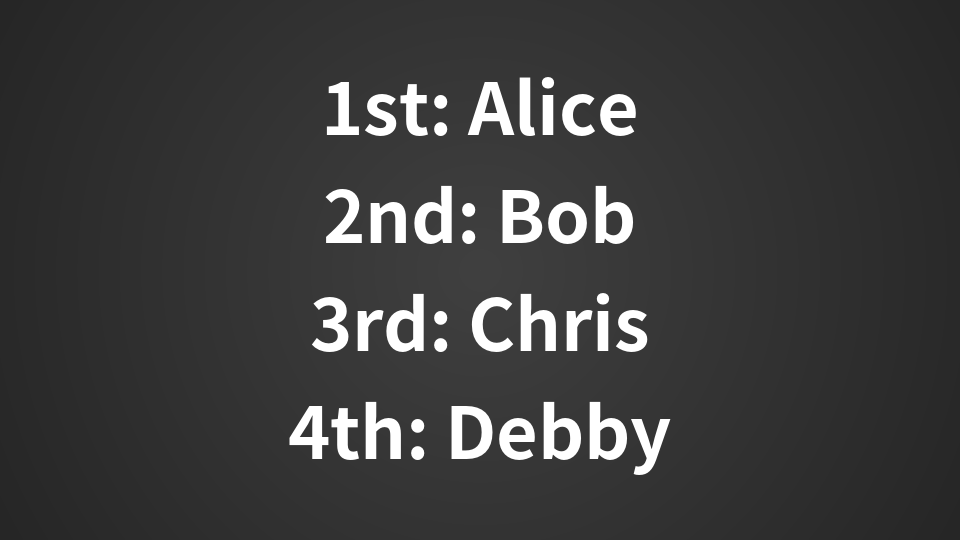

In [27]:
import glob
import math
import os
import subprocess

import ffmpeg
from PIL import Image, ImageDraw, ImageFont

from video import background_image

def rank_image(players, width=1920, height=1080):
    if width < 0:
        width = 1920
    if height < 0:
        height = 1080
    
    image = background_image(width, height)

    fontsize = int(math.sqrt(width * height / 100))
    font = ImageFont.truetype('assets/fonts/NotoSansTC-Bold.otf', fontsize)
    draw = ImageDraw.Draw(image)

    ranks = ['1st', '2nd', '3rd', '4th']

    th = draw.textsize('Test', font)[1] if len(players) > 0 else 0
    tw = [draw.textsize(f'{ranks[i]}: {players[i]}', font)[0] for i in range(len(players))]
    pos = [((width - tw[i]) / 2, (height / (len(players) + 1) / 2) * (2 * i + 2) - th / 1.5) for i in range(len(players))]

    for i in range(len(players)):
        draw.text(pos[i], f'{ranks[i]}: {players[i]}', '#FFFFFF', font)

    return image

rank_image(['Alice', 'Bob', 'Chris', 'Debby'], 960, 540)

In [86]:
video_dir = 'records_1'
output_path = os.path.abspath('result_4.mp4')
generate_video(video_dir, output_path, 'Debby', 31.28, 0.999, 75, remove_original=True)

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100

CompletedProcess(args=['ffmpeg', '-y', '-f', 'concat', '-i', 'img.txt', '-i', 'audio.wav', '-pix_fmt', 'yuv420p', '-vf', 'scale=960:540,setsar=1:1', 'tmp.mp4'], returncode=0)

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1634125724063/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100

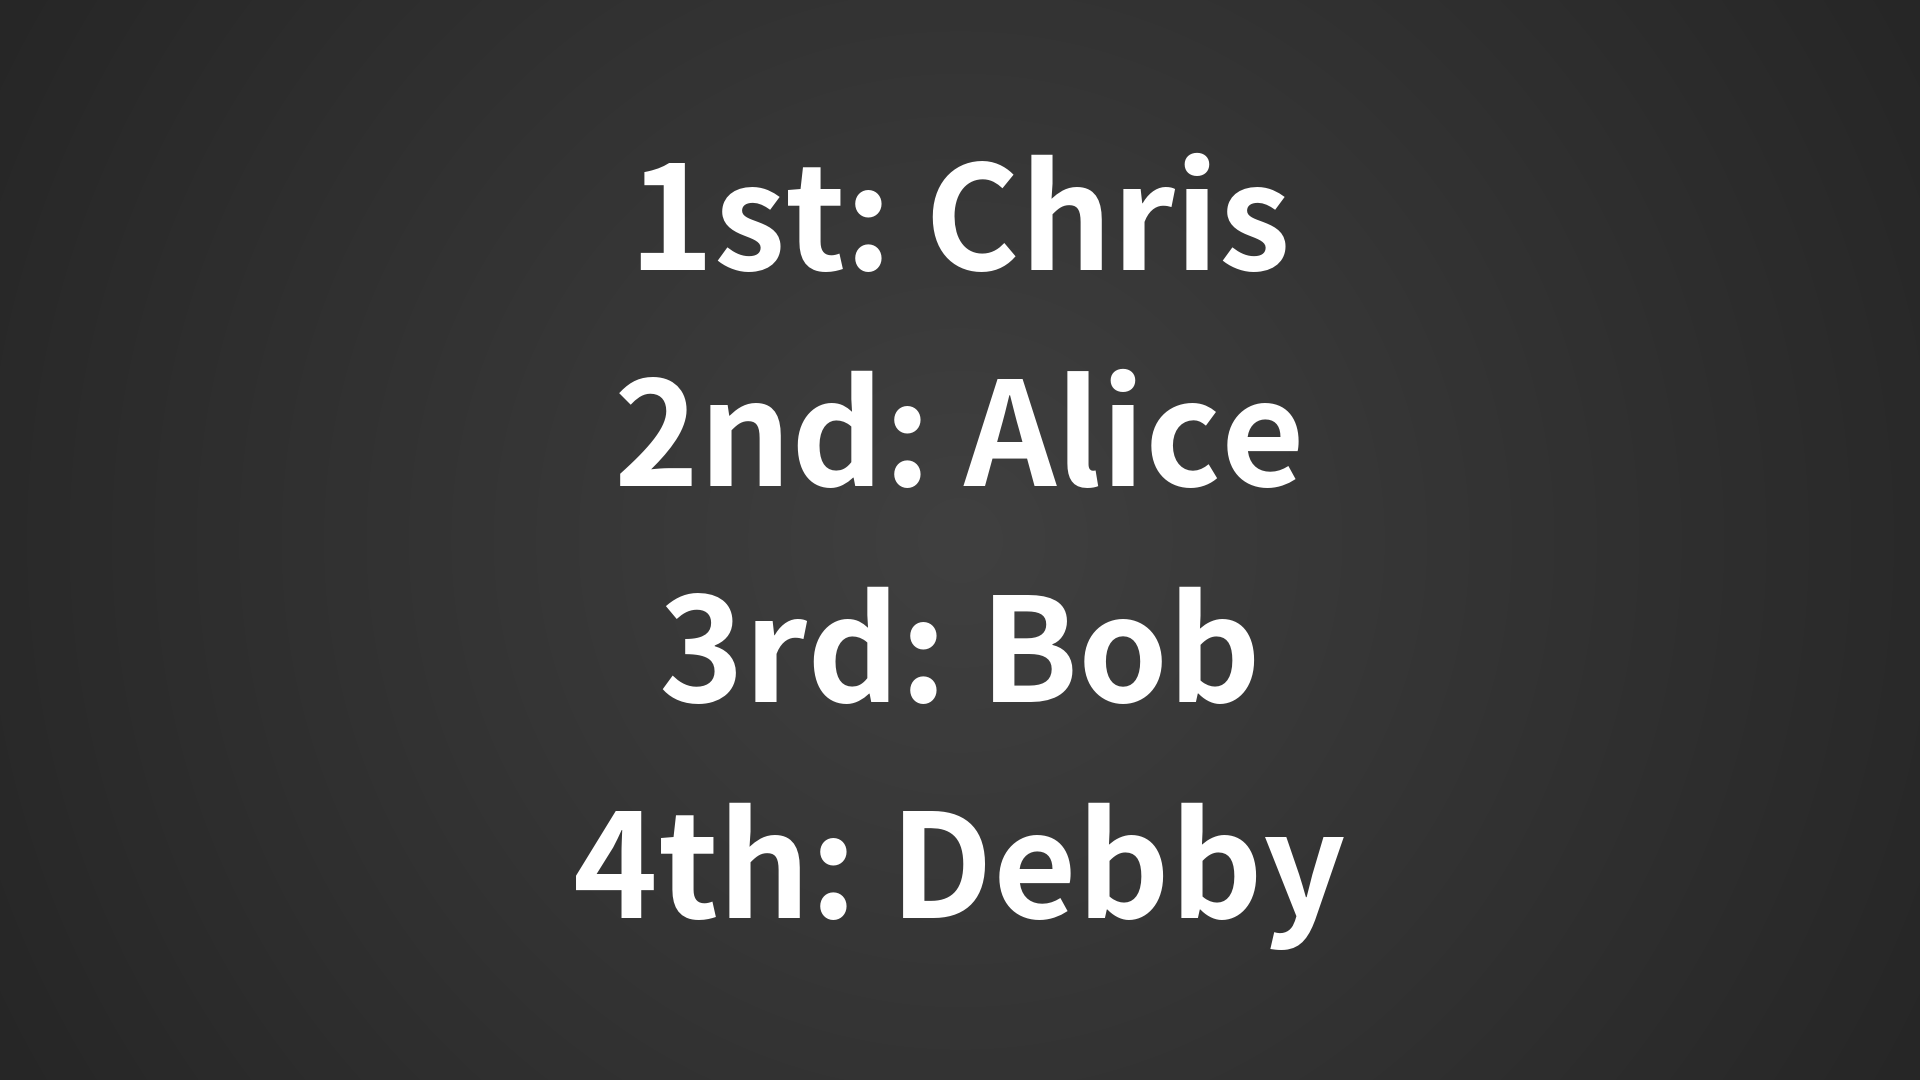

In [87]:
import glob
import math
import os
import subprocess

import ffmpeg
from PIL import Image, ImageDraw, ImageFont

from video import *

def rank_video(output_path, players, preserve_time=75, result_time=10, rank_time=5, width=1920, height=1080):
    # players: [{'rank', 'video_path'}]
    durations = [video_duration(player['video_path']) for player in players]
    duration = max(durations)
    trim_time = duration - (preserve_time - result_time)
    total_time = trim_time + rank_time

    w = []
    h = []
    pos = []
    if len(players) == 1:
        # Player 0
        w.append(width)
        h.append(height)
        pos.append((0, 0))
    if len(players) == 2:
        # Player 0
        w.append(width / 2)
        h.append(height / 2)
        pos.append((0, height / 4))
        # Player 1
        w.append(width / 2)
        h.append(height / 2)
        pos.append((width / 2, height / 4))
    if len(players) == 3:
        # Player 0
        w.append(width / 2)
        h.append(height / 2)
        pos.append((width / 4, 0))
        # Player 1
        w.append(width / 2)
        h.append(height / 2)
        pos.append((0, height / 2))
        # Player 2
        w.append(width / 2)
        h.append(height / 2)
        pos.append((width / 2, height / 2))
    if len(players) == 4:
        # Player 0
        w.append(width / 2)
        h.append(height / 2)
        pos.append((0, 0))
        # Player 1
        w.append(width / 2)
        h.append(height / 2)
        pos.append((width / 2, 0))
        # Player 2
        w.append(width / 2)
        h.append(height / 2)
        pos.append((0, height / 2))
        # Player 3
        w.append(width / 2)
        h.append(height / 2)
        pos.append((width / 2, height / 2))

    image = Image.new('RGB', (width, height)) # Create the image (with background black)
    image.save('tmp_bg.jpg')
    ranked_player = [p['id'] for p in sorted(players, key=lambda p:p['rank'])]
    rank_img = rank_image(ranked_player, width, height)
    rank_img.save('tmp_rank.jpg')

    bg = ffmpeg.input('tmp_bg.jpg')
    bgm = ffmpeg.input('assets/audio/BGM.mp3').filter('atrim', end=total_time).filter('volume', 0.5)
    v = bg
    a = []
    for i in range(len(players)):
        input = ffmpeg.input(players[i]['video_path'])
        video = input.video.trim(end=total_time).filter('scale', size=f'{int(w[i])}x{int(h[i])}', force_original_aspect_ratio='increase')
        v = v.overlay(video, x=pos[i][0], y=pos[i][1])
        a.append(input.audio)
    vr = ffmpeg.input('tmp_rank.jpg')
    v = v.overlay(vr, enable=f'between(t,{trim_time},{total_time})')
    a = ffmpeg.filter(a, 'amix', inputs=len(a)).filter('atrim', end=total_time).filter('volume', 2)
    a = ffmpeg.filter((bgm, a), 'amix', inputs=2)
    out = ffmpeg.output(v, a, output_path, pix_fmt='yuv420p')
    out.run(overwrite_output=True)

    os.remove('tmp_bg.jpg')
    os.remove('tmp_rank.jpg')
    
    return rank_img

rank_video('output.mp4', [
    {'rank': 4, 'id': 'Debby', 'video_path': 'result_4.mp4'},
    {'rank': 2, 'id': 'Alice', 'video_path': 'result_1.mp4'},
    {'rank': 3, 'id': 'Bob', 'video_path': 'result_2.mp4'},
    {'rank': 1, 'id': 'Chris', 'video_path': 'result_3.mp4'}
], 75, 10, 5, 1920, 1080)

In [31]:
import subprocess
import json

def video_duration(filepath):
    result = subprocess.run(
        f'ffprobe -v quiet -show_streams -select_streams v:0 -of json "{filepath}"',
        capture_output=True, shell=True
    ).stdout.decode()

    fields = json.loads(result)['streams'][0]

    return float(fields['duration'])

video_duration('result_1.mp4')

84.64

In [14]:
from config import ENV

# You have to check if the key exists first
if 'w' in ENV:
    ENV['w']

print(ENV.get('e'))

print(ENV.setdefault('r', '8'))

print(ENV['r'])

# You can only insert the string value
ENV['w'] = '1'

None
8
8


In [1]:
import os
import ast

from dotenv import load_dotenv

def recursive_load(path='.env', required_envs=[]):
    os.environ.pop('REQUIRE', None)
    path = os.path.abspath(path)
    load_dotenv(path)
    if 'REQUIRE' not in os.environ:
        return
    try:
        include_paths = ast.literal_eval(os.environ['REQUIRE'])
    except:
        include_paths = os.environ['REQUIRE']
    if isinstance(include_paths, str):
        if os.path.abspath(include_paths) not in required_envs:
            recursive_load(include_paths, required_envs + [path])
    for include_path in include_paths:
        if os.path.abspath(include_path) not in required_envs:
            recursive_load(include_path, required_envs + [path])

recursive_load()
print(os.environ.get('A'))
print(os.environ.get('B'))
print(os.environ.get('C'))
print(os.environ.get('D'))
print(os.environ.get('E'))

None
None
None
None
None


In [7]:
from config import ENV

ENV['VIDEO_PREFIX']
bool("false")

True

In [11]:
f = eval("lambda n: n % 3 == 0")
# f = lambda n: n % 2 == 0
print(f(1))
print(f(2))

False
False


In [14]:
fileprefix, extension = os.path.splitext(os.path.basename('dir/img.txt.mp4'))
print(fileprefix, extension)

img.txt .mp4


In [1]:
import unity

tmp_dir, output_path = unity.prepare_recording(3, filename='out.avi')
print(tmp_dir, output_path)
tmp_dir, output_path = unity.prepare_recording(3)
print(tmp_dir, output_path)
tmp_dir, output_path = unity.prepare_recording(2)
print(tmp_dir, output_path)
tmp_dir, output_path = unity.prepare_recording(enable=False)
print(tmp_dir, output_path)

None None
None None
/Users/timcsy/Library/Application Support/PAIA/kart/kart/Records/20220205131819 /Users/timcsy/Programing/Projects/PAIA/GameAI/Kart/PAIA/records/kart_20220205_131819/kart_20220205131819_2.mp4
None None


In [1]:
import unity

purename = unity.prepare_demo(3, 'rrr')
print(purename)
purename = unity.prepare_demo(2, 'rrr')
print(purename)
purename = unity.prepare_demo(2)
print(purename)
purename = unity.prepare_demo(enable=False)
print(purename)

None
rrr_2
20220205134949_2
None


In [4]:
tmp_dir, output_path = unity.prepare_recording(enable=True)
print(tmp_dir, output_path)
tmp_dir, output_path = unity.prepare_recording(enable=False)
print(tmp_dir, output_path)

/Users/timcsy/Library/Application Support/PAIA/kart/kart/Records/20220205142449 /Users/timcsy/Programing/Projects/PAIA/GameAI/Kart/PAIA/records/kart_20220205_142449/kart.mp4
None None


In [6]:
ids = {
    
}
next(iter(ids))

StopIteration: 

In [14]:
output_path = '/Users/timcsy/Programing/Projects/PAIA/GameAI/Kart/PAIA/records/kart_20220205_142449/kart.t.mp4'
rec_path = os.path.join(os.path.dirname(output_path), os.path.splitext(os.path.basename(output_path))[0] + '.rec')

/Users/timcsy/Programing/Projects/PAIA/GameAI/Kart/PAIA/records/kart_20220205_142449/kart.t.rec


In [4]:
import os
os.path.basename('/home/amninder/Desktop/Folder_2.py')

'Folder_2.py'